# Walktrhough
This notebook presents a step-by-step walkthrough of table extraction pipeline

The table extraction pipeline consists of 3 main stages:
1. Detecting and cropping tables,
2. Recognizing the structure of cropped table (columns, rows, etc.),
3. Applying OCR for each element of the table.

## Common imports

In [1]:
import os
import easyocr
import torch
from PIL import Image
from huggingface_hub import hf_hub_download
from transformers import AutoModelForObjectDetection, TableTransformerForObjectDetection

from postprocessing import outputs_to_objects
from transform import detection_transform, structure_transform
from visualize import plot_results, fig2img, visualize_detected_tables
from utils import objects_to_crops, get_cell_coordinates_by_col, apply_easyocr_for_table_name, apply_ocr_for_column_cells, classify_rows
from config import Config

## Table detection

### Load model for table detection

In [2]:
device = Config.DEVICE

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
model.to(device);

### Load image

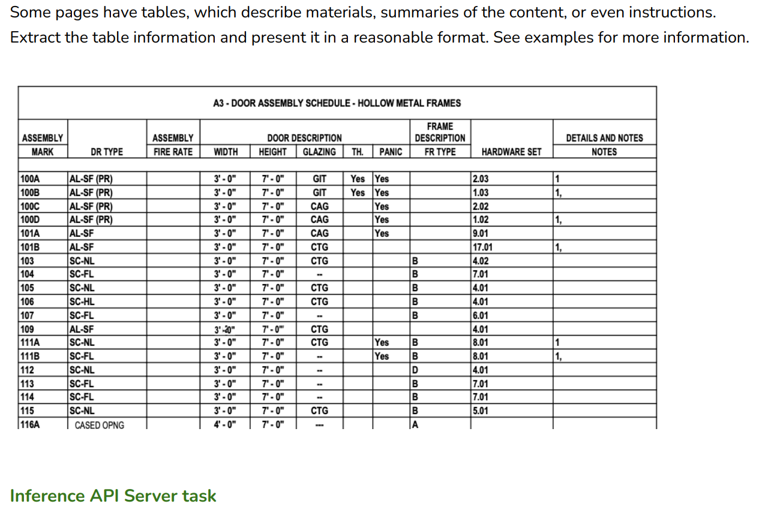

In [3]:
# file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="image.png")
# file_path = 'data/input/image_1.jpg'
# file_path = 'data/input/image_2.png'
# file_path = 'data/input/image_3.png'
file_path = 'data/input/table_example.png'

image = Image.open(file_path).convert("RGB")

# Display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

### Prepare image for the model

In [4]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 527, 800])


### Forward pass

In [5]:
with torch.no_grad():
  outputs = model(pixel_values)

### Update list of labels

In [6]:
# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

In [7]:
table_objects = outputs_to_objects(outputs, image.size, id2label, iou_threshold=1)

### Visualize result

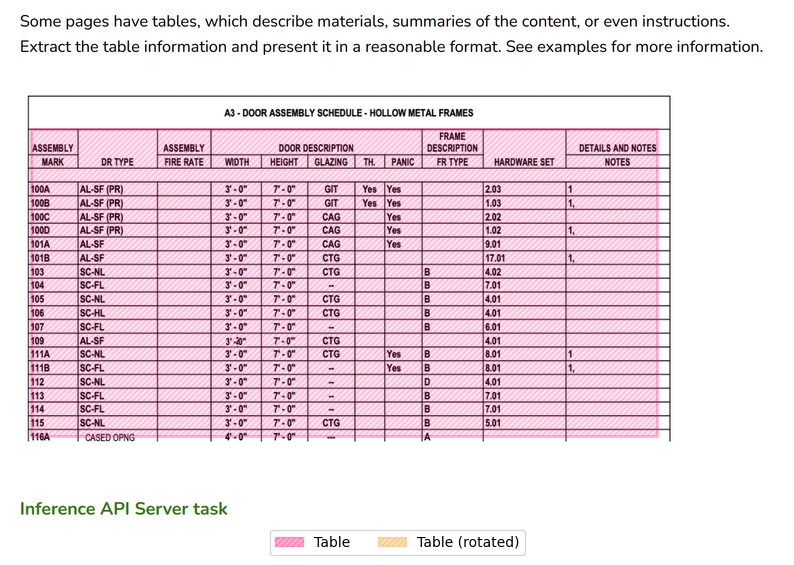

In [8]:
fig = visualize_detected_tables(image, table_objects)

In [9]:
visualized_image = fig2img(fig)

### Crop table

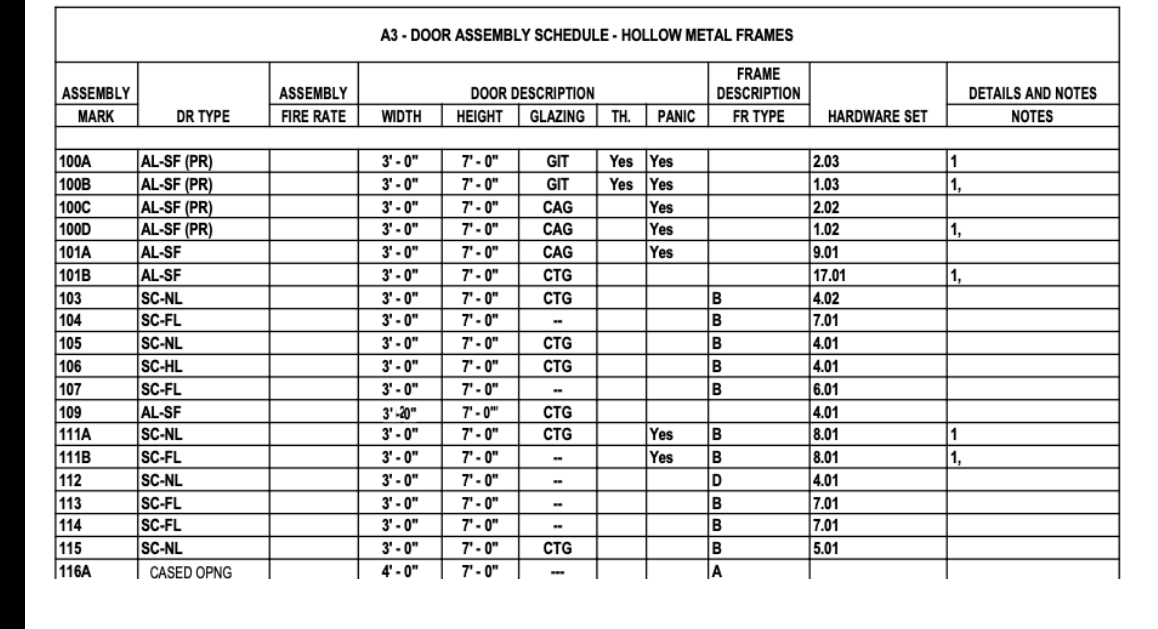

In [10]:
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 60

tables_crops = objects_to_crops(image, table_objects, detection_class_thresholds, padding=crop_padding)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [11]:
os.makedirs('data/output', exist_ok =True)
cropped_table.save("data/output/table.jpg")

## Structure recognition

### Load structure recognition model

In [12]:
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

In [13]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)

In [14]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [15]:
structure_model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [16]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

structure_objects = outputs_to_objects(outputs, cropped_table.size, structure_id2label, iou_threshold=0.95)
print(len(structure_objects))

44


### Visualize structure

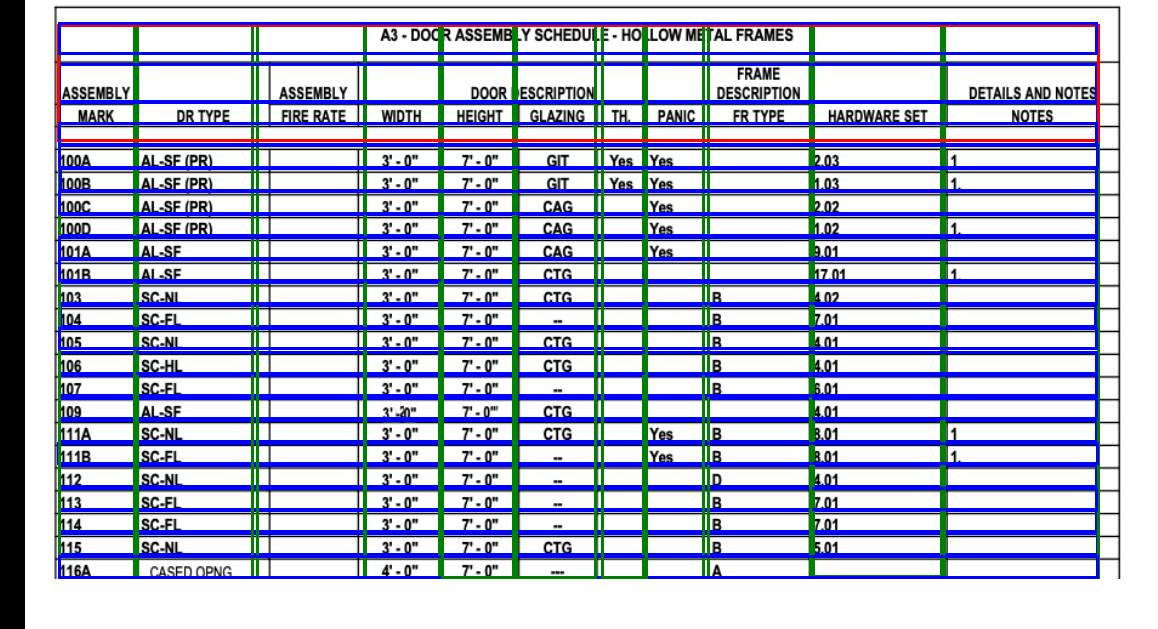

In [17]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in structure_objects:
    if cell["label"] == 'table column header':
        draw.rectangle(cell["bbox"], outline="red", width=3)
    if cell["label"] == 'table column':
        draw.rectangle(cell["bbox"], outline="green", width=3)
    if cell["label"] == 'table row':
        draw.rectangle(cell["bbox"], outline="blue", width=3)
    # if cell["label"] == 'table projected row header':
    #     draw.rectangle(cell["bbox"], outline="orange", width=3)
    # if cell["label"] == 'table spanning cell':
    #     draw.rectangle(cell["bbox"], outline="purple", width=3)
    # if cell["label"] == 'table':
    #     draw.rectangle(cell["bbox"], outline="black", width=3)

cropped_table_visualized

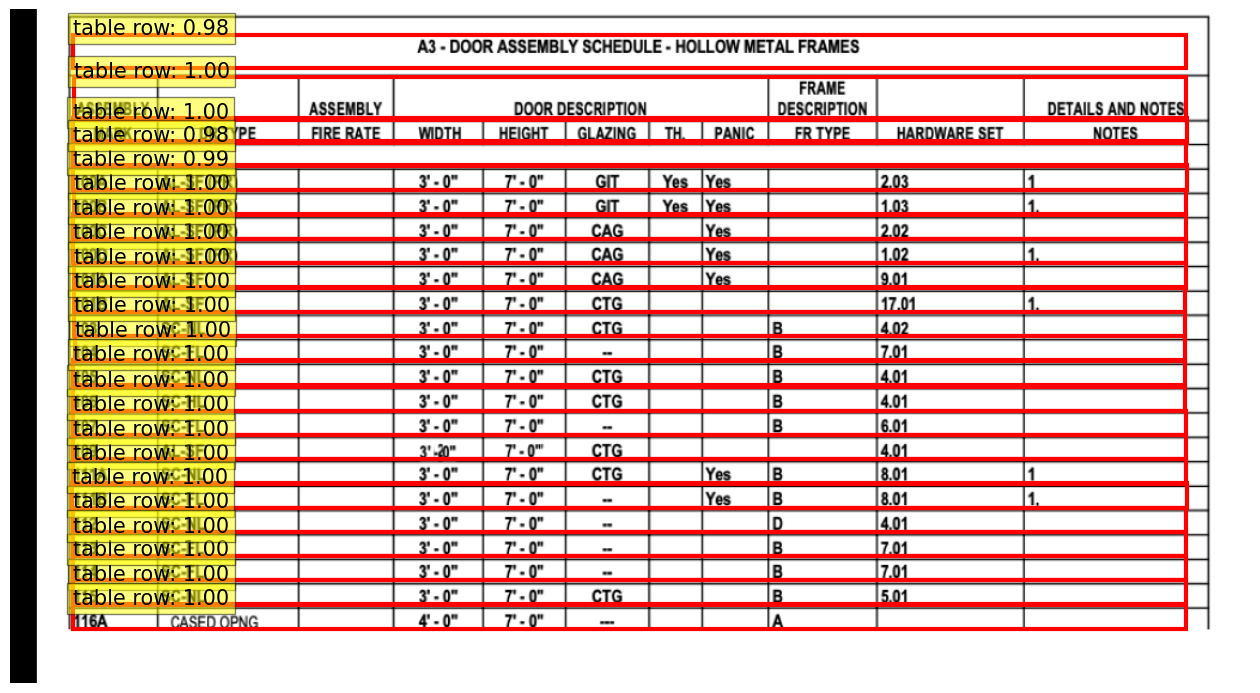

In [18]:
plot_results(structure_objects, class_to_visualize="table row", structure_model=structure_model, cropped_table=cropped_table)

## Apply OCR

In [19]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [20]:
content_rows, header_rows, table_name_row = classify_rows(structure_objects)

### Table name

In [21]:
table_name = apply_easyocr_for_table_name(cropped_table, table_name_row, easyocr_reader=reader)
table_name

'A3 - DOOR ASSEMBLY SCHEDULE - HOLLOW METAL FRAMES'

### Columns

In [22]:
column_cells_coordinates = get_cell_coordinates_by_col(structure_objects, content_rows, header_rows)
columns = apply_ocr_for_column_cells(column_cells_coordinates, cropped_table=cropped_table, easyocr_reader=reader)
columns

  0%|          | 0/11 [00:00<?, ?it/s]

[{'header': ['ASSEMBLY', 'MARK'],
  'rows': ['IOOA',
   '100B',
   '100C',
   '1OOD',
   '101A',
   'I01B',
   '403',
   '104',
   '105',
   '106',
   '107',
   '109',
   'II1A',
   'M11B',
   '112',
   '113',
   '114',
   '115',
   '116A']},
 {'header': ['DR TYPE'],
  'rows': ['IAL-SF (PRI',
   'AL- SF (PRI',
   'AL-SF (PRI',
   'AL-SF (PRI',
   'AL-SF',
   'AL-SF',
   'SC NL',
   'SC-FL',
   'SC-NL',
   'Isc HL',
   'SC-FL',
   'AL-SF',
   'Isc -NL',
   'SC FL',
   'SC-NL',
   'SC FL',
   'ISC -FL',
   'SC-NL',
   'CASED OPNG']},
 {'header': ['ASSEMBLY', 'FIRE RATE'], 'rows': []},
 {'header': ['WDTH'],
  'rows': ['3\' .0"',
   '3\' .0"',
   '3\' .0"',
   '3\' . 0"',
   '3\' .0"',
   '3\' .0"',
   '3\' . 0"',
   '3\' .0"',
   '3\' . 0"',
   '3\' . 0"',
   '3\' . 0"',
   '3\' . 0"',
   '3\' . 0"',
   '3\' .0"',
   '3\' .0"',
   '3\' .0"',
   '4.0"']},
 {'header': ['DOOR', 'HEIGHT'],
  'rows': ['7\'.0"',
   "7'.0",
   '7\'.0"',
   '7\'.0"',
   '7\'.0"',
   "7'.0",
   '7\'.0"',
   '7\'.0